In [1]:
import pyscf
import pyscf.lo
from pyscf.tools import cubegen
import matplotlib.pyplot as plt
import numpy as np

eV = 27.2114

In [2]:
mol = pyscf.gto.M(
    atom="H 0. 0. 0.; H 0. 0. 2",
    basis='ccpvdz',
    )

mf = pyscf.scf.RHF(mol)
mf.kernel()

converged SCF energy = -0.921908594114885


-0.9219085941148846

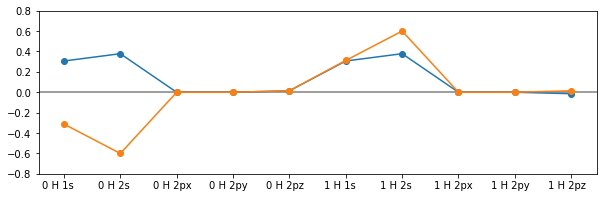

In [3]:
plt.figure(figsize=(10,3))

for i in np.arange(2):
  plt.plot(mf.mo_coeff[:,i], marker='o')

plt.axhline(0, color = 'grey', zorder=-1)
plt.ylim([-0.8,0.8])
plt.xticks(np.arange(10), mol.ao_labels())
plt.savefig('mo.pdf',bbox_inches='tight')

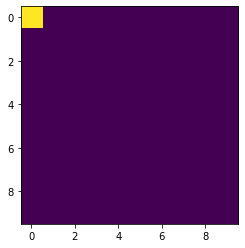

In [4]:
rdm1_ao = mf.make_rdm1()
B = mf.get_ovlp() @ mf.mo_coeff
rdm1_mo = np.einsum('ai, ab, bj->ij', B, rdm1_ao, B)
plt.imshow(rdm1_mo)
plt.savefig('rdm1_mo.pdf',bbox_inches='tight')

In [5]:
np.trace(rdm1_mo)

2.0000000000000004

In [6]:
a = pyscf.lo.iao.iao(mol, mf.mo_coeff[:,:2])#, minao='minao') 
a = pyscf.lo.vec_lowdin(a, mf.get_ovlp())

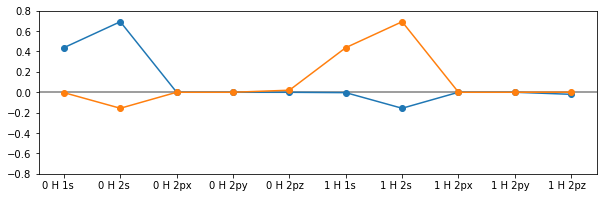

In [7]:
plt.figure(figsize=(10,3))

for i in np.arange(2):
  plt.plot(a[:,i], marker='o')

plt.axhline(0, color = 'grey', zorder=-1)
plt.ylim([-0.8,0.8])
plt.xticks(np.arange(10), mol.ao_labels())
plt.savefig('iao.pdf',bbox_inches='tight')

In [8]:
def plot_orbital(orbital, output):
    plt.figure()
    range = np.max(np.abs(orbital))
    cm = plt.imshow(orbital[orbital.shape[0]//2,:,:], cmap='bwr',vmin=-range, vmax=range, aspect = 0.5)
    plt.xlabel('z grid index')
    plt.ylabel('y grid index')
    plt.colorbar()
    plt.savefig(output,bbox_inches='tight')

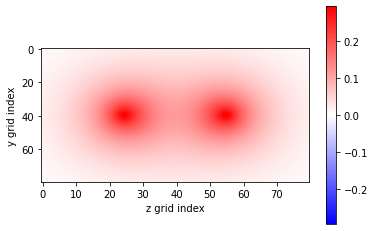

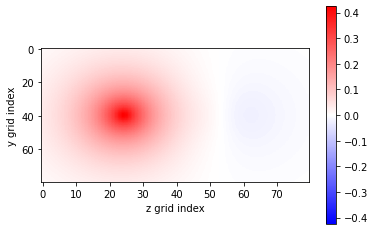

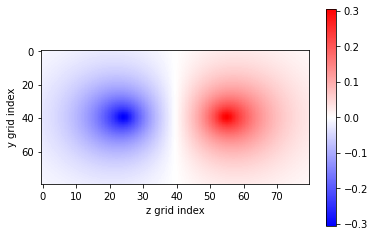

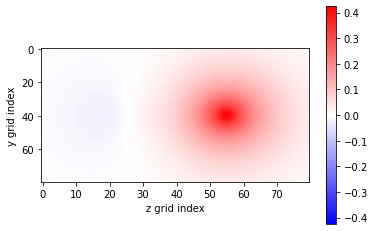

In [9]:
# plot mo and iao
for i in np.arange(2):
  mo = cubegen.orbital(mol, f'h2_mo{i}.cube', mf.mo_coeff[:,i])
  iao = cubegen.orbital(mol, f'h2_iao{i}.cube', a[:,i])
  plot_orbital(mo, f'h2_mo{i}.pdf')
  plot_orbital(iao, f'h2_iao{i}.pdf')

In [10]:
R = np.einsum("ij,ik,kl->jl" , a, mf.get_ovlp(), mf.mo_coeff[:,:2])
print(R)

# Note that the rotation matrix is unitary.
print(R @ R.conj().T)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[1.00000000e+00 1.66533454e-16]
 [1.66533454e-16 1.00000000e+00]]


In [15]:
# rotate the Hamiltonian
H0 = np.array([[mf.mo_energy[0],0],[0,mf.mo_energy[1]]])

H_tb = np.einsum("ij,jk,kl->il", R, H0, R.conj().T)
print('tb model:\n', H_tb)


tb model:
 [[-0.21078147 -0.17493142]
 [-0.17493142 -0.21078147]]


In [12]:
eigvals, eigvecs = np.linalg.eigh(H_tb)

print('tb model eigenvalues:', eigvals)
print('original eigenvalues:', mf.mo_energy[:2])

tb model eigenvalues: [-0.38571289 -0.03585005]
original eigenvalues: [-0.38571289 -0.03585005]


In [13]:
print(eigvecs)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [14]:
# compute the rotated rdm1
rdm1_iao = np.einsum("ij,jk,kl->il", R, rdm1_mo[:2,:2], R.conj().T)
print(rdm1_iao)

[[1. 1.]
 [1. 1.]]
